# Tense prediction

In [67]:
import codecs
import re
import numpy as np
from sklearn.model_selection import train_test_split

In [13]:
from estnltk import Text

### Read corpora

In [3]:
with codecs.open("cleaned-tc-tok-train_1M.en", "r", "utf8") as f:
    en = [line.strip() for line in f]
with codecs.open("cleaned-tc-tok-train_1M.et", "r", "utf8") as f:
    et = [line.strip() for line in f]

In [79]:
en = np.asarray(en)
et = np.asarray(et)

In [80]:
print(len(en), len(et))

1000000 1000000


### Grep for future tense markers

In [83]:
pattern = re.compile("(.*)((will)|(won &apos;t)|((am|is|are|&apos;re|&apos;s|&apos;m)( not)? going to))")

Find all matched strings:

In [168]:
labels = np.asarray([1 if re.match(pattern, string) else 0 for string in en])

Select equal number of future tense strings and other:

In [169]:
CLASS_SIZE = 2000

In [170]:
np.random.seed(42)
ind_fut = np.random.choice(np.where(labels == 1)[0], CLASS_SIZE)
ind_oth = np.random.choice(np.where(labels == 0)[0], CLASS_SIZE)
print(len(ind_fut), len(ind_oth))

2000 2000


Check matched sentences:

In [171]:
matched = en[ind_fut]
matched[:20]

array(['“ I will ! ” said Tom .',
       'while legislative harmonisation will not suffice to reduce these differences and will need to be supplemented by practical cooperation among Member States , adopting a sound European legal framework is an absolute prerequisite for the Union to implement a common European asylum system in an adequate and effective manner , just as it has repeatedly pledged to do so .',
       'and then it will go off !',
       'turns out it &apos;s going to be a blip on the 1 1 : 00 news after all .',
       'I &apos;II clobber you ! I &apos;m going to bash your face in !',
       'I &apos;m going to go last . I hope that &apos;s okay .',
       'the same responsibility also applies across the supply chain , where the market supervision authorities will carry out quality checks and will ensure that products on sale fully comply with the high safety requirements .',
       'at least this time , you won &apos;t be going there as an initiate .',
       'by mid-201

### Create train and test sets

In [172]:
X = np.concatenate([et[ind_fut], et[ind_oth]])
y = np.concatenate([labels[ind_fut], labels[ind_oth]])
print(len(X), len(y))

4000 4000


In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print([len(a) for a in (X_train, X_test, y_train, y_test)])

[3200, 800, 3200, 800]


Check balancing:

In [174]:
print([len(np.where(a == 1)[0]) for a in (y_train, y_test)])

[1584, 416]


Sets are balanced, we are ready to train.

______

## Train the network

In [113]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

In [114]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100

Tokenizer:

In [175]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15319 unique tokens.


In [176]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (4000, 1000)
Shape of label tensor: (4000, 2)


Split the data:

In [177]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=10)

In [178]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [179]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         1532000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 1,693,202
Trainable params: 1,693,202
Non-trainable params: 0
_________________________________________________________________


In [180]:
history = model.fit(
    X_train, 
    y_train, 
    validation_split=0.3, 
    shuffle=True,
    epochs=10, 
    batch_size=200)

Train on 2240 samples, validate on 960 samples
Epoch 1/10
2240/2240 [==============================] - 572s - loss: 0.7426 - acc: 0.5888 - val_loss: 0.6299 - val_acc: 0.6833
Epoch 2/10
2240/2240 [==============================] - 721s - loss: 0.5929 - acc: 0.6973 - val_loss: 0.5917 - val_acc: 0.6885
Epoch 3/10
2240/2240 [==============================] - 911s - loss: 0.5219 - acc: 0.7317 - val_loss: 0.5776 - val_acc: 0.6948
Epoch 4/10
2240/2240 [==============================] - 924s - loss: 0.4190 - acc: 0.8192 - val_loss: 0.5624 - val_acc: 0.6969
Epoch 5/10
2240/2240 [==============================] - 1023s - loss: 0.2960 - acc: 0.8924 - val_loss: 0.5935 - val_acc: 0.6906
Epoch 6/10
2240/2240 [==============================] - 940s - loss: 0.4061 - acc: 0.8661 - val_loss: 1.6077 - val_acc: 0.4719
Epoch 7/10


KeyboardInterrupt: 

In [147]:
model.save_weights('lstm_fut_binary_model_1k.h5')

with open('lstm_fut_model_1k_def.json','w') as ff:
    json_string = model.to_json()
    ff.write(json_string)

In [149]:
import matplotlib.pyplot as plt

In [150]:
def plot_learning_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.clf()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

plot_learning_curve(history)

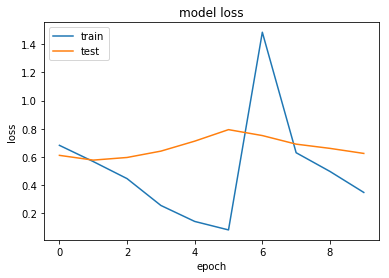

In [151]:
plt.show()

### Accuracy

In [152]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
0.705


### Confusion matrix

In [160]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test[:,0], y_pred[:,0]))

[[164  41]
 [ 77 118]]


### Misclassified

In [ ]:
false_positive = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 0))
false_negative = np.intersect1d(np.where(y_pred == 0), np.where(y_test == 1))

------

## Estonian sentences

Split by clauses

In [14]:
class PresText(Text):

    def __init__(self, sentence):
        Text.__init__(self, sentence)
        self.present_indices = self.present_ind()
        self.clauses_with_present = self.clauses_present()

    def present_ind(self):
        present_tags = ['b', 'd', 'ge', 'gem', 'gu', 'ks', 'ksid', 'ksime', 'ksin', 'ksite', 'me', 'n', 'neg ge',
                        'neg gem', 'neg gu', 'neg ks', 'meg me', 'neg o', 'neg vat', 'o', 'ta', 'tagu', 'taks',
                        'takse', 'tav', 'tavat', 'te', 'v', 'vad', 'vat']
        return [i for i, t in enumerate(self.get.forms.as_list[0]) if t in present_tags]

    def clauses_present(self):
        clauses_present = [self.clause_texts[j] for j in [self.clause_indices[i] for i in self.present_indices]]
        return clauses_present